In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from LPLDataset import FileModulatedPoissonGroup

In [11]:
import os
def mk_folder(folder_name):

    current_directory = os.getcwd()

    path = os.path.join(current_directory, folder_name)

    if not os.path.exists(path):
        os.makedirs(path)  
        print(f"Folder '{folder_name}' created in {current_directory}")

In [12]:
mk_folder('rates')
mk_folder('spks')
mk_folder('outs')

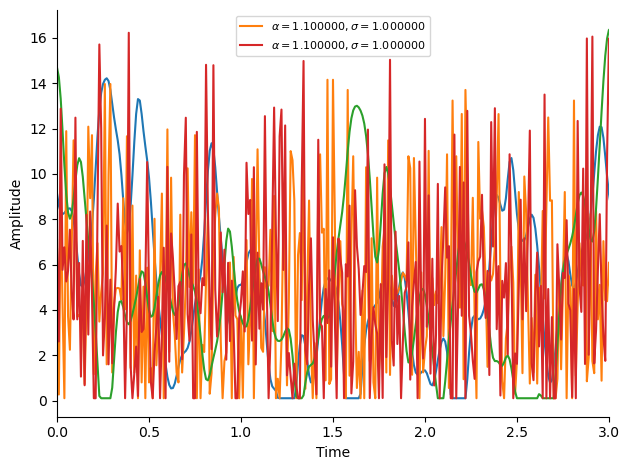

In [13]:
folder_name='rates'

sampling_interval = 10e-3 # sampling interval
baserate = 5.0
amplitude = 4.0
basename = "rates"


np.random.seed(42)

def get_random_signal(period=10.0, alpha=1.5, nb_repeats=11, cutoff=128):
    theta = np.random.rand(cutoff,2)
    duration = period*nb_repeats
    times = np.arange(0,duration,sampling_interval)
    signal = 0.0
    for i,params in enumerate(theta):
        a,b = params
        signal += 1.0/alpha**i*a*np.sin(2*np.pi*i*(times+b)/period)

    signal = (signal-np.mean(signal))/(np.std(signal)+1e-4)
    return times,signal

#Make rates0.dat with constant firing rate
duration = 100.0
with open("%s/%dhz_rates0.dat"%(folder_name, int(baserate)),'w') as fp:
    fp.write("0 %e\n"%baserate)
    fp.write("%e %e\n"%(duration,baserate))
    
plt.figure()
filecount = 1



# Make periodic slow signals and controls
alphas = [1.1, 1.1]
multipliers = [1.0, 1.0]
period = [3.0, 3.0 + 1/13]
for k in range(len(alphas)):
    times,signal = get_random_signal(period=period[k],alpha=alphas[k])
    values = np.clip(multipliers[k]*amplitude*signal+baserate,0.1,np.inf)
    with open("%s/%dhz_%s%i.dat"%(folder_name,int(baserate),basename,filecount),'w') as fp:
        for p in zip(times,values):
            fp.write("%e %e\n"%p)
    plt.plot(times,values)
    filecount += 1  

    # Make shuffle control
    np.random.shuffle(values)
    with open("%s/%dhz_%s%i.dat"%(folder_name,int(baserate),basename,filecount),'w') as fp:
        for p in zip(times,values):
            fp.write("%e %e\n"%p)
    plt.plot(times,values,label=r'$\alpha=%f,\sigma=%f$'%(alphas[k],multipliers[k]))
    filecount += 1


# Plot connectivity for visual inspection
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.xlim((0,3.0))
plt.legend(fontsize=8)
plt.tight_layout()
sns.despine()
plt.savefig("%s/%dhz_rates.pdf"%(folder_name,int(baserate)))

In [14]:
dt = 1e-4
rates_file_path_list = [
    "rates/%dhz_rates0.dat"%(int(baserate)),
    "rates/%dhz_rates1.dat"%(int(baserate)),
    "rates/%dhz_rates2.dat"%(int(baserate)),
    "rates/%dhz_rates3.dat"%(int(baserate)),
    "rates/%dhz_rates4.dat"%(int(baserate)),
] 
spikes_file_path1 = "spks/%dhz_spikes_50000s.ras"%(int(baserate))
spikes_file_path2 = "spks/%dhz_spikes_100s.ras"%(int(baserate))
duration1 = 50000 
duration2 = 100
print(rates_file_path_list)

['rates/5hz_rates0.dat', 'rates/5hz_rates1.dat', 'rates/5hz_rates2.dat', 'rates/5hz_rates3.dat', 'rates/5hz_rates4.dat']


In [15]:
input_spikes = FileModulatedPoissonGroup(time_step=dt)
input_spikes.mk_spikes(rates_file_path_list, spikes_file_path1, time=duration1, neurons=100)
input_spikes.mk_spikes(rates_file_path_list, spikes_file_path2, time=duration2, neurons=100)


In [7]:
data = np.loadtxt("spks/5hz_spikes_100s.ras")
times = data[:, 0]
neuron_ids = data[:, 1]

In [8]:
t_dur = 5.0
start_time = 0.0
end_time = start_time + t_dur
mask = (times >= start_time) & (times <= end_time)
filtered_times = times[mask] - start_time
filtered_neuron_ids = neuron_ids[mask]

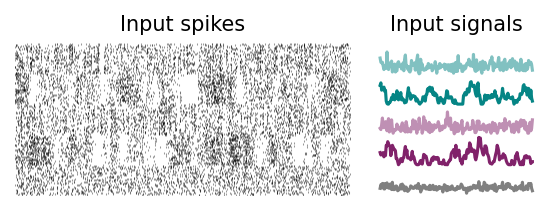

In [9]:
%matplotlib inline

marker_size = 0.8
lw = 0.5
alpha = 0.7

bin_duration = 25e-3
input_group_size = 100
nb_inputs = 500

fig = plt.figure(figsize=(3.8, 1.5), dpi=150)
gs = GridSpec(1, 2, width_ratios=[2, 1])


ax1 = plt.subplot(gs[0])
ax1.set_title("Input spikes", fontsize=10)
sc = ax1.scatter(filtered_times, filtered_neuron_ids, marker='|', s=marker_size, alpha=0.4, c='black', linewidths=lw)
ax1.set_xlim((0, t_dur))
ax1.set_ylim((0, nb_inputs))
ax1.set_ylabel('Input spikes', fontsize=8)
ax1.axis("off")
sns.despine(ax=ax1)


binned_input = np.zeros((int(t_dur/bin_duration), nb_inputs//input_group_size))
for row in np.column_stack((filtered_times, filtered_neuron_ids)):
    t, i = row[0], row[1]
    idx = int(t//bin_duration)
    binned_input[idx, int(i//input_group_size)] += 1.0

colors = ['gray', '#81226A', '#81226A', '#058585', '#058585']
alphas = [1., 1., 0.5, 1., 0.5]
offset = 50
offs = np.arange(5) * offset

ax2 = plt.subplot(gs[1])
for i in range(5):
    ax2.plot(binned_input[:, i] + offs[i], color=colors[i], alpha=alphas[i])
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Binned input')
ax2.set_title("Input signals", fontsize=10)
ax2.set_ylim((0, 5 * offset))
ax2.axis("off")

plt.tight_layout()
plt.savefig("spks/spike_train.png")
plt.show()
